In [1]:
pip install openimages # install the openimages library

     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 133kB 27.5MB/s 
     |████████████████████████████████| 137.3MB 88kB/s 
     |████████████████████████████████| 296kB 30.0MB/s 
     |████████████████████████████████| 71kB 12.0MB/s 
     |████████████████████████████████| 6.7MB 54.7MB/s 
  Created wheel for ImageHash: filename=ImageHash-4.1.0-py2.py3-none-any.whl size=291991 sha256=4a13f5a6a7c36787e115f01748bf3cfac0e21614b176b45f3a635643160145c9
  Stored in directory: /root/.cache/pip/wheels/07/1c/dc/6831446f09feb8cc199ec73a0f2f0703253f6ae013a22f4be9
Successfully built ImageHash
ERROR: botocore 1.19.15 has requirement urllib3<1.26,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


In [2]:
# import the libraries for the project
import os
from openimages.download import download_dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn
import numpy as np
import shutil

In [3]:
image_cnt = 600 # number of images from each category
download_dataset('/tmp/images', ['Bird', 'Boot','Sunglasses'], annotation_format='pascal', limit=image_cnt) # download the images into the /tmp/images forder

2020-11-11  20:27:32 INFO NumExpr defaulting to 2 threads.
2020-11-11  20:27:34 INFO Downloading 600 train images for class 'bird'
100%|██████████| 600/600 [00:05<00:00, 101.02it/s]
2020-11-11  20:27:41 INFO Creating 600 train annotations (pascal) for class 'bird'
100%|██████████| 600/600 [00:00<00:00, 1858.09it/s]
2020-11-11  20:27:42 INFO Downloading 600 train images for class 'boot'
100%|██████████| 600/600 [00:06<00:00, 86.16it/s]
2020-11-11  20:27:49 INFO Creating 600 train annotations (pascal) for class 'boot'
100%|██████████| 600/600 [00:00<00:00, 2461.88it/s]
2020-11-11  20:27:50 INFO Downloading 600 train images for class 'sunglasses'
100%|██████████| 600/600 [00:06<00:00, 92.66it/s]
2020-11-11  20:27:56 INFO Creating 600 train annotations (pascal) for class 'sunglasses'
100%|██████████| 600/600 [00:00<00:00, 2692.90it/s]


{'bird': {'annotations_dir': '/tmp/images/bird/pascal',
  'images_dir': '/tmp/images/bird/images'},
 'boot': {'annotations_dir': '/tmp/images/boot/pascal',
  'images_dir': '/tmp/images/boot/images'},
 'sunglasses': {'annotations_dir': '/tmp/images/sunglasses/pascal',
  'images_dir': '/tmp/images/sunglasses/images'}}

In [4]:
# directory names of the downloaded images
base_dir = '/tmp/images'
bird_dir = os.path.join(base_dir, 'bird/images')
boot_dir = os.path.join(base_dir, 'boot/images')
sunglasses_dir = os.path.join(base_dir, 'sunglasses/images')

# lis the file names of the downloaded images and concatenate them to the directory they are in
bird_fnames = os.listdir(bird_dir)
boot_fnames = os.listdir(boot_dir)
sunglasses_fnames = os.listdir(sunglasses_dir)
for i in range(image_cnt):
  bird_fnames[i] = os.path.join(bird_dir, bird_fnames[i])
  boot_fnames[i] = os.path.join(boot_dir, boot_fnames[i])
  sunglasses_fnames[i] = os.path.join(sunglasses_dir, sunglasses_fnames[i])

# split the image file name array to train, validation and test arrays
bird_train, bird_2 = train_test_split(bird_fnames, test_size=1/3, shuffle=True)
bird_valid, bird_test = train_test_split(bird_2, test_size=1/2, shuffle=True)
boot_train, boot_2 = train_test_split(boot_fnames, test_size=1/3, shuffle=True)
boot_valid, boot_test = train_test_split(boot_2, test_size=1/2, shuffle=True)
sunglasses_train, sunglasses_2 = train_test_split(sunglasses_fnames, test_size=1/3, shuffle=True)
sunglasses_valid, sunglasses_test = train_test_split(sunglasses_2, test_size=1/2, shuffle=True)

# directories for the train, validation and test data
train_dir = '/tmp/train'
valid_dir = '/tmp/valid'
test_dir = '/tmp/test'

# create the folders for the train, validation and test data and copy the images to the appropriate folder
try:
  os.mkdir(train_dir)
  os.mkdir(os.path.join(train_dir, 'bird'))
  os.mkdir(os.path.join(train_dir, 'boot'))
  os.mkdir(os.path.join(train_dir, 'sunglasses'))
except:
  print("Train folder already exists.")
for i in bird_train:
  shutil.copy(i, os.path.join(train_dir, 'bird'))
for i in boot_train:
  shutil.copy(i, os.path.join(train_dir, 'boot'))
for i in sunglasses_train:
  shutil.copy(i, os.path.join(train_dir, 'sunglasses'))

try:
  os.mkdir(valid_dir)
  os.mkdir(os.path.join(valid_dir, 'bird'))
  os.mkdir(os.path.join(valid_dir, 'boot'))
  os.mkdir(os.path.join(valid_dir, 'sunglasses'))
except:
  print("Validation folder already exists.")
for i in bird_valid:
  shutil.copy(i, os.path.join(valid_dir, 'bird'))
for i in boot_valid:
  shutil.copy(i, os.path.join(valid_dir, 'boot'))
for i in sunglasses_valid:
  shutil.copy(i, os.path.join(valid_dir, 'sunglasses'))

try:
  os.mkdir(test_dir)
  os.mkdir(os.path.join(test_dir, 'bird'))
  os.mkdir(os.path.join(test_dir, 'boot'))
  os.mkdir(os.path.join(test_dir, 'sunglasses'))
except:
  print("Test folder already exists.")
for i in bird_test:
  shutil.copy(i, os.path.join(test_dir, 'bird'))
for i in boot_test:
  shutil.copy(i, os.path.join(test_dir, 'boot'))
for i in sunglasses_test:
  shutil.copy(i, os.path.join(test_dir, 'sunglasses'))

In [ ]:
# input image size of the downloaded model
img_height=299
img_width=299

base_model = InceptionV3(weights='imagenet', include_top=False) # download the inception_v3 model without the top layer
x = base_model.output
x = GlobalAveragePooling2D()(x) # to flatten the 2D convolution
x = Dense(2048, activation='relu')(x) # new layer of 2048 neurons with relu activation
predictions = Dense(3, activation='softmax')(x) # the output layer consists of 3 neurons for each category
model = Model(inputs=base_model.input, outputs=predictions) # create our model

In [ ]:
# make all layers in the downloaded model untrainable
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy') # compile our model with the appropriate parameters

In [ ]:
# function to enrich the downloaded data to train our model
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)
# data generators to train our model
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=20, class_mode='categorical', shuffle=True)
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(img_height, img_width), batch_size=20, class_mode='categorical', shuffle=True)

Found 1200 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [ ]:
checkpoint1 = ModelCheckpoint(filepath='/tmp/model1.h5', save_best_only=True, verbose=0) # save the trained model into a file, since training can be time consuming
model.fit_generator(train_generator, steps_per_epoch=60, validation_data=valid_generator, validation_steps=10, epochs=3, callbacks=[checkpoint1]) # train our model

Epoch 1/3
60/60 [==============================] - 245s 4s/step - loss: 1.0613 - accuracy: 0.7883 - val_loss: 0.1805 - val_accuracy: 0.9350
Epoch 2/3
60/60 [==============================] - 243s 4s/step - loss: 0.1401 - accuracy: 0.9567 - val_loss: 0.1915 - val_accuracy: 0.9400
Epoch 3/3
60/60 [==============================] - 243s 4s/step - loss: 0.1800 - accuracy: 0.9367 - val_loss: 0.1656 - val_accuracy: 0.9400


In [ ]:
test_fnames = bird_test + boot_test + sunglasses_test # test file names (concatenated to the directory they are in) into one array
test_input = []
# load and preprocess each test image and put them into one array which will be the input of the model during testing
for i in test_fnames:
  img = image.load_img(i, target_size=(299, 299))
  x = image.img_to_array(img)
  x = preprocess_input(x)
  test_input.append(x)
test_input = np.asarray(test_input) # the created test input array as numpy array
# create the test output array
test_output = np.full(shape=(100), fill_value=0)
test_output = np.concatenate((test_output, np.full(shape=(100), fill_value=1)), axis=0)
test_output = np.concatenate((test_output, np.full(shape=(100), fill_value=2)), axis=0)
test_input, test_output = shuffle(test_input, test_output) # shuffle the testing input and output array the same way

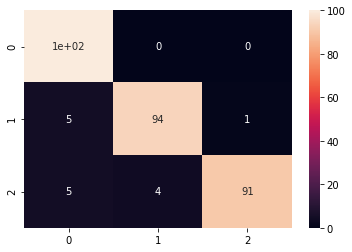

In [ ]:
model = load_model('/tmp/model1.h5') # load our trained model from the file
predict = model.predict(test_input) # predict the output for all test images
conf_matrix = confusion_matrix(test_output, np.argmax(predict, axis=1)) # create a confusion matrix from the model output and the correct solution of the test database
seaborn.heatmap(conf_matrix, annot=True) # show the results on a heatmap

In [ ]:
# make the layers from the 172. layer trainable
for layer in model.layers[172:]:
       layer.trainable = True

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'], loss='categorical_crossentropy') # compile our model with the appropriate parameters

In [ ]:
checkpoint2 = ModelCheckpoint(filepath='/tmp/model2.h5', save_best_only=True, verbose=0) # save the trained model into a file, since training can be time consuming
model.fit_generator(train_generator,steps_per_epoch=60, validation_data=valid_generator, validation_steps=10, epochs=3, callbacks=[checkpoint2]) # train our model

Epoch 1/3
60/60 [==============================] - 416s 7s/step - loss: 0.2527 - accuracy: 0.9125 - val_loss: 0.1466 - val_accuracy: 0.9550
Epoch 2/3
60/60 [==============================] - 416s 7s/step - loss: 0.1782 - accuracy: 0.9458 - val_loss: 0.1483 - val_accuracy: 0.9400
Epoch 3/3
60/60 [==============================] - 416s 7s/step - loss: 0.1314 - accuracy: 0.9567 - val_loss: 0.1384 - val_accuracy: 0.9450


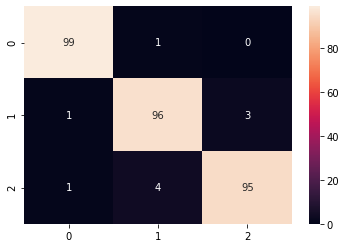

In [ ]:
model = load_model('/tmp/model2.h5') # load our trained model from the file
predict = model.predict(test_input) # predict the output for all test images
conf_matrix = confusion_matrix(test_output, np.argmax(predict, axis=1)) # create a confusion matrix from the model output and the correct solution of the test database
seaborn.heatmap(conf_matrix, annot=True) # show the results on a heatmap